<a href="https://colab.research.google.com/github/washwin/RamSpec_Bacterial_Classification/blob/main/convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# --- 0. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# --- 1. Load Data ---
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')

In [29]:
# --- 2. Prepare Features and Labels ---
X = df.drop(columns=['label', 'Class']).values
y = df['label']

# Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [30]:
# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape input for Conv1D
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# One-hot encode labels
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=len(le.classes_))
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=len(le.classes_))

In [31]:
# --- 4. Define Model ---
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(len(le.classes_), activation='softmax')
])

# --- 5. Compile Model ---
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --- 6. Train Model ---
history = model.fit(
    X_train, y_train_onehot,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.1176 - loss: 19.6813 - val_accuracy: 0.0903 - val_loss: 2.2222 - learning_rate: 0.0010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2050 - loss: 8.0620 - val_accuracy: 0.1389 - val_loss: 2.2253 - learning_rate: 0.0010
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2533 - loss: 4.2416 - val_accuracy: 0.0833 - val_loss: 2.2774 - learning_rate: 0.0010
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2719 - loss: 3.0782 - val_accuracy: 0.1458 - val_loss: 2.2187 - learning_rate: 0.0010
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3109 - loss: 2.3871 - val_accuracy: 0.1042 - val_loss: 2.2812 - learning_rate: 0.0010
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4147 - loss: 1.7154 - val_accuracy: 0.1042 - val_loss: 2.2373 - learning_rate: 0.0010
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4984 - loss: 1.5574 - val_accur

In [32]:
# --- 7. Evaluate Model ---
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predict and evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)


Test Accuracy: 0.9553
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Classification Report:
                         precision    recall  f1-score   support

Enterobacter_aerogenes       0.96      0.92      0.94        25
 Enterococcus_faecalis       0.93      0.93      0.93        14
       Eschericia_coli       1.00      0.94      0.97        17
      Listeria_innocua       1.00      0.96      0.98        27
Listeria_monocytogenes       0.86      1.00      0.92        18
     Rhodococcus_equii       1.00      0.94      0.97        16
               S_abony       1.00      1.00      1.00        24
        Shigella_boydi       0.95      0.91      0.93        22
 Staphylococcus_aureus       0.89      1.00      0.94        16

              accuracy                           0.96       179
             macro avg       0.95      0.96      0.95       179
          weighted avg       0.96      0.96      0.96       179



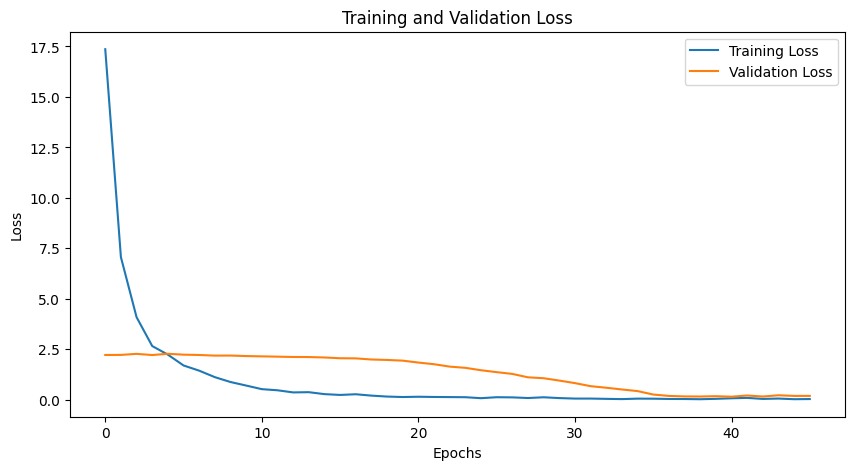

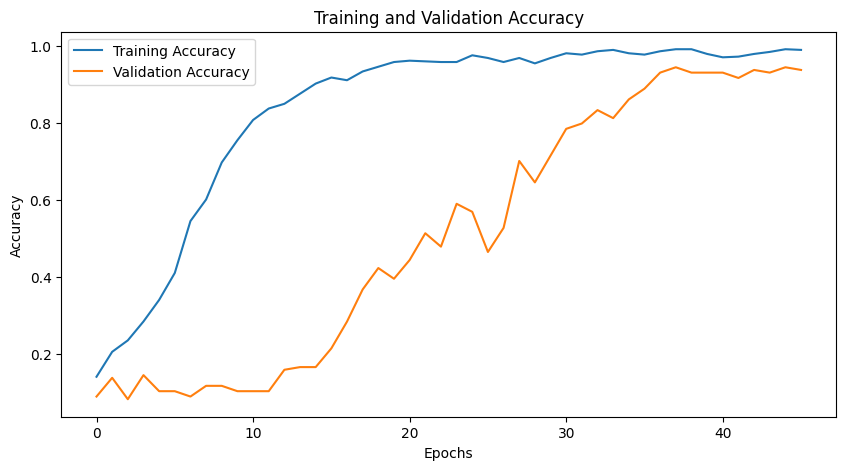

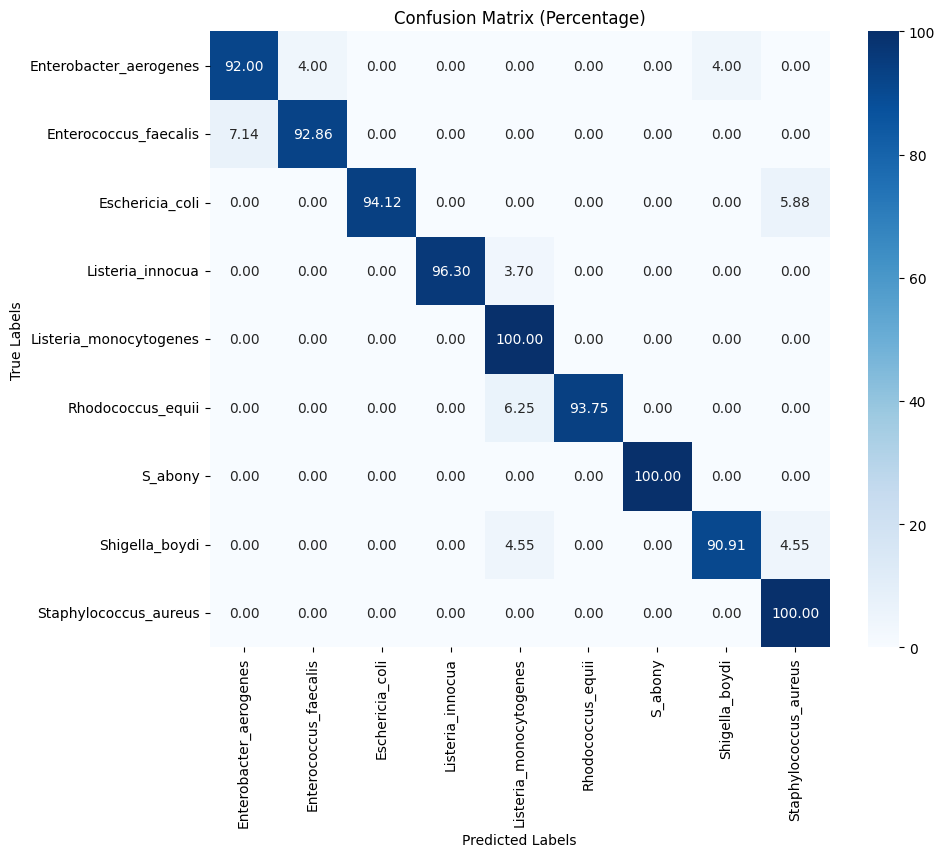

In [33]:
# --- 8. Visualize Results ---

# 1. Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3. Confusion Matrix (Percentage)
conf_matrix_percent = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
